In [ ]:
import math
import random
import csv
import sys
import operator
import pickle
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from shapely.geometry import Polygon, Point

import cvxpy as cp

import keras
from keras import layers
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.special import comb, perm
import time

In [ ]:
# !pip install Ipython --upgrade
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Mount Google Drive Folder

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
rootPath = '/content/drive/Shareddrives/KW phase1 repo'

Mounted at /content/drive


In [ ]:
import sys
sys.path.append(rootPath+'/package')
from utils.env_sdp_realRSS import env
from model.uav import UAV

In [ ]:
savePath = '/content/drive/Shareddrives/KW phase1 repo/datas/anomalySDPResult/0906_realRSS_10-26'

## AE 

### Read Rawdata from csv



In [ ]:
socpResultsDatas = []
for j in range(env.N_ngps):
  with open(savePath+"/test_position{}_pickerror0_300.csv".format(j), "r") as _csv:
    csvReader = list(csv.reader(_csv, delimiter=',', quoting=csv.QUOTE_NONNUMERIC))
    print(len(csvReader))
    socpResultsDatas.append(csvReader)

# socpResultsDatas = np.maximum(socpResultsDatas, 0)

5800
5800
5800
5800


In [ ]:
# a = [[-1, 2, 2], [2, 2, 2], [2, 2, -1]]
# np.maximum(socpResultsDatas, 0)

In [ ]:
np.array(socpResultsDatas).shape

(4, 5800, 3)

### Read UAV Position

In [ ]:
f = open(savePath+"/UAVsSamples_100.pkl", "rb")
UAVsSamples = pickle.load(f)
print(UAVsSamples)

{0: {'ESP01': <model.uav.UAV object at 0x7f3aa51c2f10>, 'ESP02': <model.uav.UAV object at 0x7f3b1107de10>, 'ESP03': <model.uav.UAV object at 0x7f3b1107d910>, 'ESP04': <model.uav.UAV object at 0x7f3b1107db50>, 'ESP05': <model.uav.UAV object at 0x7f3b1107dd50>, 'ESP06': <model.uav.UAV object at 0x7f3b1107de50>, 'ESP07': <model.uav.UAV object at 0x7f3b1107dc50>, 'ESP08': <model.uav.UAV object at 0x7f3b1107df90>, 'ESP09': <model.uav.UAV object at 0x7f3b1107db10>, 'ESP10': <model.uav.UAV object at 0x7f3b1107ddd0>, 'ESP11': <model.uav.UAV object at 0x7f3b1107dcd0>}, 1: {'ESP01': <model.uav.UAV object at 0x7f3b1107ded0>, 'ESP02': <model.uav.UAV object at 0x7f3b1107d950>, 'ESP03': <model.uav.UAV object at 0x7f3b1107dfd0>, 'ESP04': <model.uav.UAV object at 0x7f3b1107dd10>, 'ESP05': <model.uav.UAV object at 0x7f3b1107dbd0>, 'ESP06': <model.uav.UAV object at 0x7f3b1107dd90>, 'ESP07': <model.uav.UAV object at 0x7f3b1107dad0>, 'ESP08': <model.uav.UAV object at 0x7f3b1107db90>, 'ESP09': <model.uav.U

In [ ]:
assert(np.array(socpResultsDatas).shape[0] == env.N_ngps)
assert(np.array(socpResultsDatas).shape[2] == env.DIMENSION)
groupSize =0
for i in np.arange(env.DIMENSION+2,env.N_gps+1,1):
  groupSize += comb(env.N_gps,i)
groupSize = int(groupSize)
print(np.array(socpResultsDatas).shape[1]//env.SAMPLES)
assert(np.array(socpResultsDatas).shape[1]//env.SAMPLES == groupSize)

29


### Loading sample from data

In [ ]:
# load parsed UAVSamples
f = open(savePath+"/shiftUAVSamples.pkl", "rb")
parsedUAVSamples = pickle.load(f)
len(parsedUAVSamples)

200

In [ ]:
# load parsed rawDatas
f = open(savePath+"/shiftRawDatas.pkl", "rb")
rawDatas = pickle.load(f)
np.array(rawDatas).shape

(4, 200, 29, 3)

In [ ]:
# rawDatas = []
# ReadSampleSize = env.LOAD_SAMPLES_FOR_AE
# for i in range(env.N_ngps):
#   temp = []
#   for j in range(ReadSampleSize):
#     temp.append(socpResultsDatas[i][j*groupSize : j*groupSize+groupSize])
#   rawDatas.append(temp)

In [ ]:
# assert(np.array(rawDatas).shape[1] ==  env.LOAD_SAMPLES_FOR_AE)

In [ ]:
_anchorSamples = []
anchorSamples = []
ReadSampleSize = env.SAMPLES
for sample in range(ReadSampleSize):
  temp = []
  for id, uav in UAVsSamples[sample].items():
    if not uav.observedPosition == None:
      temp.append([uav.observedPosition for i in range(groupSize)])
  _anchorSamples.append(temp)
for i in range(env.N_gps):
  temp = []
  for sample in range(ReadSampleSize):
    temp.append(_anchorSamples[sample][i])
  anchorSamples.append(temp)

In [ ]:
# list(map(lambda i: rawDatas.append(anchorSamples[i]), range(env.N_gps)))
# None
# assert(np.array(rawDatas).shape[0] == env.N)

In [ ]:
np.array(rawDatas).shape

(4, 200, 29, 3)

In [ ]:
np.max(rawDatas)

633.9430125112491

### Devide Test and Training set


In [ ]:
ReadSampleSize = np.array(rawDatas).shape[1]
testingSampleSize = int(( ReadSampleSize * env.TEST_PERCENTAGE )//1)
if testingSampleSize == 0:
  testingSampleSize = 1
traningSampleSize = int(ReadSampleSize-testingSampleSize)
rawTrainingData = list(map( lambda item: item[:-testingSampleSize], rawDatas))
rawTestingData =  list(map( lambda item: item[traningSampleSize:], rawDatas))
print(np.array(rawTrainingData).shape)
print(np.array(rawTestingData).shape)

(4, 180, 29, 3)
(4, 20, 29, 3)


In [ ]:
dualGroupingTrainingData = []
dualGroupingTestingData = []
def dualFunc(X,i,j): 
    temp = []
    for index_1, e1 in enumerate(X[i][j]):
      for index_2, e2 in enumerate(X[i][j]):
        if not index_1 == index_2:
          temp.append([e1, e2])
    return temp

rawTrainingDataShape = np.array(rawTrainingData).shape
rawTestingDataShape = np.array(rawTestingData).shape
for i in range(rawTrainingDataShape[0]):
  trainingS = list(map(lambda j: dualFunc(rawTrainingData,i,j),np.arange(0,rawTrainingDataShape[1])))
  testingS = list(map(lambda j: dualFunc(rawTestingData,i,j),np.arange(0,rawTestingDataShape[1])))
  dualGroupingTrainingData.append(trainingS)
  dualGroupingTestingData.append(testingS)

_trainingDataShape = np.array(dualGroupingTrainingData).shape
_testingDataShape= np.array(dualGroupingTestingData).shape
_reshapeTrainingData = []
_reshapeTestingData = []
def swapFunc(j,X,shapeOfX,targetReformSlice): 
  for sample in range(shapeOfX[1]): #sample
    temp = []
    for i in range(shapeOfX[0]):
      temp.append(X[i][sample][j])
    targetReformSlice.append(temp) 
list(map(lambda _sample: swapFunc(_sample,dualGroupingTrainingData,_trainingDataShape,_reshapeTrainingData), range(_trainingDataShape[2]))) #8556
list(map(lambda _sample: swapFunc(_sample,dualGroupingTestingData,_testingDataShape,_reshapeTestingData), range(_testingDataShape[2])))
print("")
VAETrainingData = np.array(_reshapeTrainingData).reshape(len(_reshapeTrainingData), np.prod(np.array(_reshapeTrainingData).shape[1:]))
VAETestingData = np.array(_reshapeTestingData).reshape(len(_reshapeTestingData), np.prod(np.array(_reshapeTestingData).shape[1:]))

In [ ]:
shapeOfRawTrainingData = np.array(rawTrainingData).shape
assert(np.array(VAETrainingData).shape[1] == shapeOfRawTrainingData[0]*shapeOfRawTrainingData[3]*2)
assert(np.array(VAETestingData).shape[1] == shapeOfRawTrainingData[0]*shapeOfRawTrainingData[3]*2)

In [ ]:
shapeOfRawTrainingData

(4, 180, 29, 3)

### normorlization


In [ ]:
# data_min = 0
# data_max = max(max(env.X_RANGE,env.Y_RANGE),env.Z_RANGE)

# data_max = max(np.max(VAETrainingData),np.max(VAETrainingData))
# data_min = min(np.min(VAETrainingData),np.min(VAETestingData))
upperThreshold = 0.95
lowerThreshold = 0.05
VAETrainingData_flatten = VAETrainingData.flatten()
VAETrainingData_flatten.sort()
data_max, data_min = VAETrainingData_flatten[int(len(VAETrainingData_flatten)*upperThreshold)],VAETrainingData_flatten[int(len(VAETrainingData_flatten)*lowerThreshold)]
# data_min = np.min(VAETrainingData_flatten)
print(data_max, data_min)

# print(np.min(VAETrainingData), np.max(VAETrainingData))
# print(np.min(VAETestingData), np.max(VAETestingData))

normalizeVAETrainingData = (VAETrainingData-data_min)/(data_max - data_min)
normalizeVAETrainingData = normalizeVAETrainingData.astype('float32')
np.clip(normalizeVAETrainingData, 0,1, out=normalizeVAETrainingData)
# normalizeVAETrainingData = (VAETrainingData-np.min(VAETrainingData))/(np.max(VAETrainingData) - np.min(VAETrainingData))
# normalizeVAETrainingData = normalizeVAETrainingData.astype('float32')

normalizeVAETestingData = (VAETestingData-data_min)/(data_max - data_min)
normalizeVAETestingData = normalizeVAETestingData.astype('float32')
# normalizeVAETestingData = (VAETestingData-np.min(VAETestingData))/(np.max(VAETestingData) - np.min(VAETestingData))
# normalizeVAETestingData = normalizeVAETestingData.astype('float32')

26.596492222686464 -3.9510938431348284


In [ ]:
X_train = normalizeVAETrainingData
y_train = normalizeVAETestingData

In [ ]:
print(np.array(X_train).shape)
print(np.array(y_train).shape)

(146160, 24)
(16240, 24)


In [ ]:
print(_reshapeTrainingData[0])
print(normalizeVAETrainingData)

[[array([12.57000795, -1.5960519 , 25.86254338]), array([1.38686928, 1.5798984 , 1.37914303])], [array([ 8.70126514,  2.36302933, 29.15742987]), array([1.53182466, 1.34259828, 1.2064422 ])], [array([ 9.93097934,  0.23902861, 27.76154058]), array([1.76844655, 1.9649947 , 1.08514366])], [array([11.11349592,  0.62111503, 27.74729357]), array([1.85259332, 1.0677908 , 0.49749629])]]
[[0.5408317  0.0770942  0.9759736  ... 0.1899884  0.16429725 0.1456282 ]
 [0.5177548  0.48140487 0.62664723 ... 0.37236023 0.7919606  0.49213043]
 [0.13617583 0.51612616 0.40932402 ... 0.22286211 0.40039247 0.48377582]
 ...
 [0.18543486 0.8365345  0.6739212  ... 0.20236881 0.         0.        ]
 [0.14385775 0.7703005  0.58562636 ... 0.20714954 0.         0.        ]
 [0.15350214 0.93885136 0.7325896  ... 0.20358992 0.8776027  0.73816216]]


In [ ]:
batch_size = env.batch_size
latent_dim = env.latent_dim
intermediate_dim =env.intermediate_dim
final_dim = env.final_dim
epochs = env.epochs
epsilon_std = env.epsilon_std

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
originalShape = X_train.shape[1:]
originalDimaintion = np.prod(originalShape)
print(originalShape)
in_layer = Input(shape=originalShape)
x = Flatten()(in_layer)
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(final_dim, activation = 'relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_f = Dense(final_dim, activation='relu')
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(originalDimaintion, activation='sigmoid')

f_decoded = decoder_f(z)
h_decoded = decoder_h(f_decoded)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_img = Reshape(originalShape)(x_decoded_mean)

# instantiate VAE model
vae = Model(in_layer, x_decoded_img)

# Compute VAE loss
xent_loss = originalDimaintion * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.summary()

(24,)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24)]         0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 24)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           1600        flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
________________________________________________________________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = vae.fit(X_train, X_train, 
        epochs=100, 
        batch_size=batch_size, 
        shuffle=True,
        validation_data=(y_train, y_train),
        callbacks=[callback],
        ).history

Epoch 1/100
18/18 [==============================] - 1s 29ms/step - loss: 15.2833 - val_loss: 14.0662
Epoch 2/100
18/18 [==============================] - 0s 28ms/step - loss: 15.2766 - val_loss: 13.8920
Epoch 3/100
18/18 [==============================] - 1s 28ms/step - loss: 15.2745 - val_loss: 13.8395
Epoch 4/100
18/18 [==============================] - 1s 28ms/step - loss: 15.2677 - val_loss: 13.7337
Epoch 5/100
18/18 [==============================] - 0s 28ms/step - loss: 15.2626 - val_loss: 13.6008
Epoch 6/100
18/18 [==============================] - 1s 29ms/step - loss: 15.2562 - val_loss: 13.4996
Epoch 7/100
18/18 [==============================] - 0s 26ms/step - loss: 15.2566 - val_loss: 13.3988
Epoch 8/100
18/18 [==============================] - 0s 27ms/step - loss: 15.2508 - val_loss: 13.2962
Epoch 9/100
18/18 [==============================] - 0s 27ms/step - loss: 15.2411 - val_loss: 13.1843
Epoch 10/100
18/18 [==============================] - 0s 27ms/step - loss: 15.2391

In [ ]:
vae.save(rootPath+"/datas/trainingModelReal/VAENoanchorModel_200sample_7UAV_4uUAV_"+str(round(time.time() * 1000)))

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/KW phase1 repo/datas/trainingModelReal/VAENoanchorModel_200sample_7UAV_4uUAV_1631113178296/assets


In [ ]:
# modelPath = rootPath+"/datas/trainingModel/VAENoanchorModel_300sample_8UAV_8uUAV_div20"
# loadVae = keras.models.load_model(modelPath, custom_objects={'latent_dim': env.latent_dim, 'epsilon_std': env.epsilon_std})

In [ ]:
# vae = loadVae

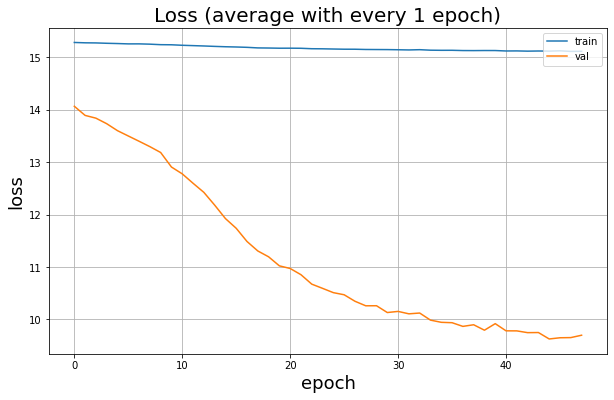

In [ ]:
fig = plt.figure(figsize=(10,6))
acc = []
valAcc = []
step = 1
for i in range(len(history['loss'])//step):
  acc.append(np.mean(history['loss'][i:i+step:1]))
  valAcc.append(np.mean(history['val_loss'][i:i+step:1]))

plt.plot(acc)
plt.plot(valAcc)
plt.title('Loss (average with every {} epoch)'.format(step), fontsize=20)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.grid()
plt.legend(['train', 'val'], loc='upper right')

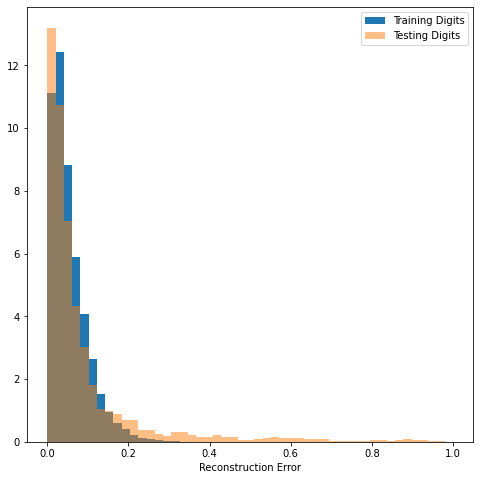

In [ ]:
model_mse = lambda x: np.mean(np.square(x-vae.predict(x, batch_size = batch_size)), axis=1)
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(X_train), bins = np.linspace(0, 1, 50), label = 'Training Digits', density = True, alpha = 1.0)
ax1.hist(model_mse(y_train), bins = np.linspace(0, 1, 50), label = 'Testing Digits', density = True, alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

In [ ]:
import numpy as np, scipy.stats as st
trainMSE = model_mse(X_train)
lower,upper = st.t.interval(0.95, len(trainMSE)-1, loc=np.mean(trainMSE), scale=st.sem(trainMSE))
print(len(trainMSE),upper)
trainMSE = trainMSE[trainMSE < upper]
print(len(trainMSE))
trainMean = np.mean(trainMSE)
trainStd = np.std(trainMSE)

testMSE = model_mse(y_train)
lower,upper = st.t.interval(0.95, len(testMSE)-1, loc=np.mean(testMSE), scale=st.sem(testMSE))
testMSE = testMSE[testMSE < upper]

testMean = np.mean(testMSE)
testStd = np.std(testMSE)
# anomalyMean = np.mean(model_mse(anomaly_data))
# anomalyStd = np.std(model_mse(anomaly_data))
print("{:.10f}".format(trainMean),testMean)
print(trainStd,testStd)

146160 0.05535184672180942
89908
0.0274736490 0.08912977
0.014038599 0.13419409


## diveration

0.0085604275 0.12191048
0.008034491 0.5181186


0.0085980948 0.07496701 0.0074654915 0.24208938

0.0078349933 0.16472259 0.0068685147 0.4446141

0.0063909353 0.11015087 0.006871389 0.36433458